# 4. Анализ результатов A/B-тестирования: кумулятивные метрики #

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

from scipy.stats import norm
from scipy.stats import t

In [2]:
ab_data = pd.read_csv('data/ab_data.csv')

In [3]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [5]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    290482 non-null  int64         
 1   timestamp  290482 non-null  datetime64[ns]
 2   group      290482 non-null  object        
 3   converted  290482 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 8.9+ MB


In [6]:
daily_data = ab_data.groupby(['timestamp', 'group']).agg({
    'user_id': 'count',
    'converted': 'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


###  Задание 4.1 ###

Рассчитать конверсию на каждый день по приведённой формуле. Результат занести в столбец `conversion`.
Чему была равна конверсия (в процентах) в группе **А** 5 января 2017 года?
Ответ округлить до второго знака после запятой.

***Ответ - 12.32***

In [7]:
daily_data['conversion'] = daily_data['converted'] / daily_data['users_count'] * 100
display(daily_data.loc[daily_data['timestamp'] == '2017-01-05'].loc[daily_data['group'] == 'A']['conversion'])

6    12.322792
Name: conversion, dtype: float64

## ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ ##

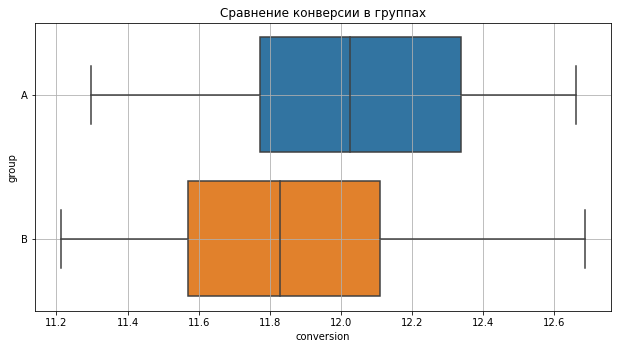

In [8]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.boxplot(
    data=daily_data,
    x='conversion',
    y='group',
    ax=ax
)
ax.set_title('Сравнение конверсии в группах')
ax.grid();

In [9]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(['mean', 'median'])
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


## КУМУЛЯТИВНЫЕ МЕТРИКИ ##

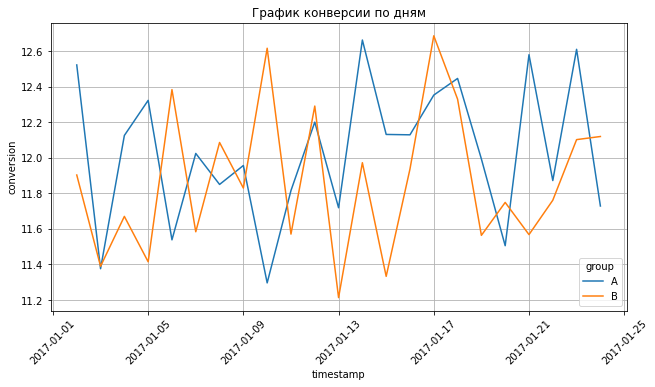

In [10]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group',
    ax=ax
)
ax.set_title('График конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True);

In [11]:
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

<ipython-input-11-b160621da665>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


In [12]:
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_converted'] / daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


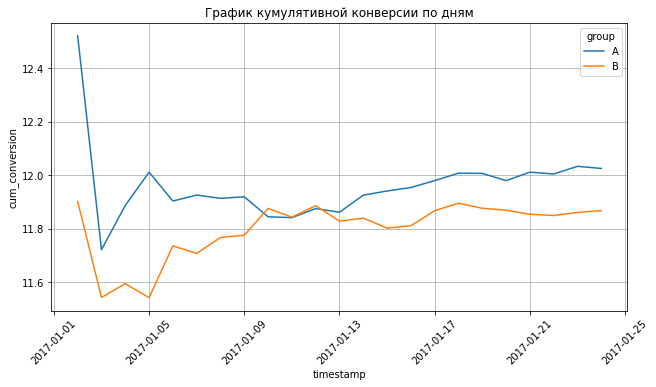

In [13]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='cum_conversion',
    hue='group',
    ax=ax
)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True);

In [14]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

In [15]:
sample_a.head()

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


In [16]:
sample_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61571 entries, 0 to 61570
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          61571 non-null  object 
 1   cid           61571 non-null  float64
 2   transactions  61571 non-null  int64  
 3   revenue       61571 non-null  int64  
 4   group         61571 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 2.3+ MB


###  Задание 4.6 ###

Построить таблицу со следующими ежедневными показателями:

- количество посетителей сайта;
- суммарное число транзакций;
- общая сумма покупок (выручка).

Для этого сгруппировать данные по признаку `date`, предварительно преобразовав его к типу `datetime`.

Чему равны значения ежедневных показателей в группе **А** на 8 ноября 2020 года?

***Ответ - количество посетителей сайта - 3354, суммарное число транзакций - 25, общая сумма покупок - 846051***

In [17]:
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')
daily_a = sample_a.groupby(['date']).agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={'cid': 'users_count'})
daily_b = sample_b.groupby(['date']).agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={'cid': 'users_count'})

display(daily_a[daily_a['date'] == '2020-11-08'])

,date,users_count,transactions,revenue
2,2020-11-08,3354,25,846051


###  Задание 4.7 ###

Добавить в каждую из таблиц кумулятивные метрики:

- кумулятивное количество посетителей сайта;
- кумулятивное суммарное число транзакций;
- кумулятивная общая сумма покупок (кумулятивная выручка).

Рассчитать кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлить до сотых.

***Ответ - A = 0.71, B = 0.76***

In [18]:
daily_a['cum_users_count'] = daily_a['users_count'].cumsum()
daily_a['cum_transactions'] = daily_a['transactions'].cumsum()
daily_a['cum_revenue'] = daily_a['revenue'].cumsum()

daily_a['cum_conversion'] = daily_a['cum_transactions'] / daily_a['cum_users_count'] * 100
daily_a['cum_avg_check'] = daily_a['cum_revenue'] / daily_a['cum_transactions']
display(daily_a.head())
display(round(daily_a['cum_conversion'].mean(), 2))

,date,users_count,transactions,revenue,cum_users_count,cum_transactions,cum_revenue,cum_conversion,cum_avg_check
0,2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-07,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
2,2020-11-08,3354,25,846051,8634,64,4145216,0.741256,64769.000000
3,2020-11-09,3234,18,708830,11868,82,4854046,0.690934,59195.682927
4,2020-11-10,3022,29,826984,14890,111,5681030,0.745467,51180.450450


0.71

In [19]:
daily_b['cum_users_count'] = daily_b['users_count'].cumsum()
daily_b['cum_transactions'] = daily_b['transactions'].cumsum()
daily_b['cum_revenue'] = daily_b['revenue'].cumsum()

daily_b['cum_conversion'] = daily_b['cum_transactions'] / daily_b['cum_users_count'] * 100
daily_b['cum_avg_check'] = daily_b['cum_revenue'] / daily_b['cum_transactions']
display(daily_b.head())
display(round(daily_b['cum_conversion'].mean(), 2))

,date,users_count,transactions,revenue,cum_users_count,cum_transactions,cum_revenue,cum_conversion,cum_avg_check
0,2020-11-06,2499,19,996645,2499,19,996645,0.760304,52455.000000
1,2020-11-07,2804,19,555499,5303,38,1552144,0.716576,40845.894737
2,2020-11-08,3291,24,3044842,8594,62,4596986,0.721434,74144.935484
3,2020-11-09,3062,25,1285836,11656,87,5882822,0.746397,67618.643678
4,2020-11-10,3072,30,2414726,14728,117,8297548,0.794405,70919.213675


0.76

###  Задание 4.8 ###

Построить графики кумулятивной конверсии в каждой группе. Какие выводы по ним можно сделать?

***Ответ - Начиная с 9 ноября 2020 года конверсии в группах имеют приблизительно идентичное поведение (одинаковые точки роста и спада). При этом конверсия в группе B стабильно выше конверсии в группе A на данном периоде.***

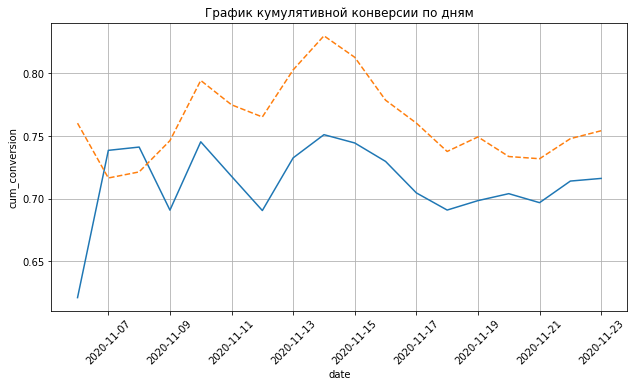

In [20]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=daily_a,
    x='date',
    y='cum_conversion',
    ax=ax
)
sns.lineplot(
    data=daily_b,
    x='date',
    y='cum_conversion',
    linestyle='dashed',
    ax=ax
)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True);

###  Задание 4.9 ###

Построить графики кумулятивного среднего чека в каждой группе. Какие выводы по ним можно сделать?

***Ответ - В начале периода наблюдения средний чек в группе B был меньше, чем средний чек в группе A. Однако при стабилизации метрик наблюдается обратный результат.***

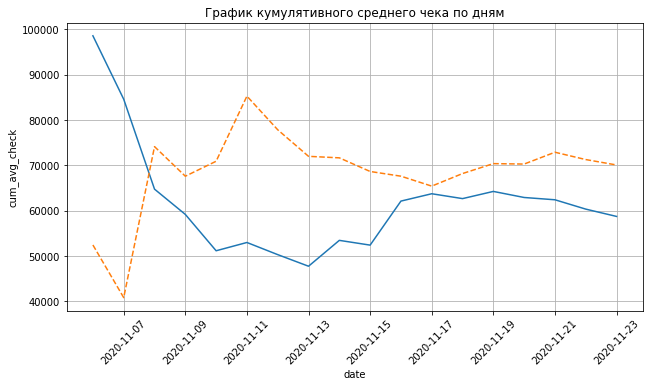

In [21]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=daily_a,
    x='date',
    y='cum_avg_check',
    ax=ax
)
sns.lineplot(
    data=daily_b,
    x='date',
    y='cum_avg_check',
    linestyle='dashed',
    ax=ax
)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True);

# 5. Анализ результатов A/B-тестирования: статистические тесты #

## СТАТИСТИЧЕСКИЙ ТЕСТ ДЛЯ КОНВЕРСИИ ##

In [22]:
converted_piv = ab_data.groupby('group')['converted'].agg(['sum', 'count'])
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


In [23]:
H0 = 'Конверсии в группах A и B равны'
H1 = 'Конверсия в группе A выше, чем конверсия в группе B'
alpha = 0.05

stat, p_alue = proportions_ztest(
    count=converted_piv['sum'],
    nobs=converted_piv['count'],
    alternative='larger'
)
print('p_value =', round(p_alue, 2))
if p_alue < alpha:
    print(f'Отвергаем нулевую гипотезу ({H0})')
    print(f'Принимаем альтернативную гипотезу ({H1})')
else:
    print(f'Принимаем нулевую гипотезу ({H0})')

p_value = 0.1
Принимаем нулевую гипотезу (Конверсии в группах A и B равны)


## СТАТИСТИЧЕСКИЕ ТЕСТЫ ДЛЯ ДРУГИХ МЕТРИК ##

In [24]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


In [25]:
time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time(A)  30 non-null     float64
 1   time(B)  30 non-null     float64
dtypes: float64(2)
memory usage: 608.0 bytes


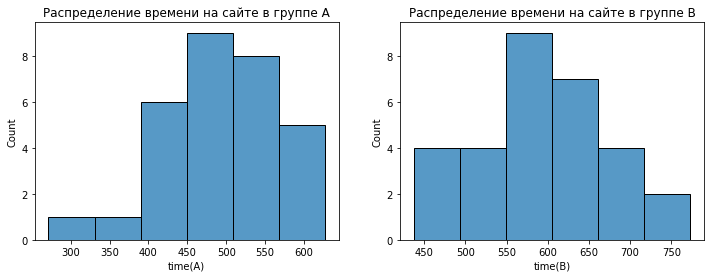

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(
    data=time_data,
    x='time(A)',
    ax=axes[0]
)
sns.histplot(
    data=time_data,
    x='time(B)',
    ax=axes[1]
)
axes[0].set_title('Распределение времени на сайте в группе A')
axes[1].set_title('Распределение времени на сайте в группе B');

### Проверка нормальности обоих распределений тестом Шапиро-Уилка ###

In [27]:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05

shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print(f'p-value группы A = {round(shapiro_result_a.pvalue, 2)}')
print(f'p-value группы B = {round(shapiro_result_b.pvalue, 2)}')

if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу ({H0})')
    print(f'Принимаем альтернативную гипотезу ({H1})')
else:
    print(f'Принимаем нулевую гипотезу ({H0})')

p-value группы A = 0.43
p-value группы B = 0.12
Принимаем нулевую гипотезу (Распределения в обеих группах нормальные)


### T-тест для сравнения средних ###

In [28]:
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе A меньше, чем в группе B'
alpha = 0.05

results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='less'
)
print(f'p-value = {round(results.pvalue, 2)}')

if results.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу ({H0})')
    print(f'Принимаем альтернативную гипотезу ({H1})')
else:
    print(f'Принимаем нулевую гипотезу ({H0})')

p-value = 0.0
Отвергаем нулевую гипотезу (Среднее время в группах одинаково)
Принимаем альтернативную гипотезу (Среднее время в группе A меньше, чем в группе B)


###  Задание 5.2 ###

Проверить гипотезу о равенстве конверсий в группах **А** и **B** при альтернативной гипотезе: Конверсия в группе **А** меньше, чем конверсия в группе **B**. Использовать функцию `proportions_ztest()` из модуля `statsmodels.stats.proportion`. В качестве уровня значимости взять $\alpha=0,1$.

Каковы результаты тестирования?

***Ответ - Конверсии в группах равны***

In [29]:
sample_ab = pd.concat([sample_a, sample_b])

In [30]:
daily_ab = sample_ab.groupby(['date', 'group']).agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={'cid': 'users_count', 'transactions': 'transactions_sum', 'revenue': 'revenue_sum'})
daily_ab['conv_users'] = daily_ab['transactions_sum'] / daily_ab['users_count'] * 100

# conv_piv = daily_ab.groupby('group')['conv_users'].agg(['mean', 'median'])
conv_piv = daily_ab.groupby('group')['conv_users'].agg(['sum', 'count'])
display(conv_piv)

,sum,count
group,,
A,13.014443,18
B,13.726118,18


In [31]:
H0 = 'Конверсии в группах A и B равны'
H1 = 'Конверсия в группе A выше, чем конверсия в группе B'
alpha = 0.1

stat, p_alue = proportions_ztest(
    count=conv_piv['sum'],
    nobs=conv_piv['count'],
    alternative='larger'
)
print('p_value =', round(p_alue, 2))
if p_alue < alpha:
    print(f'Отвергаем нулевую гипотезу ({H0})')
    print(f'Принимаем альтернативную гипотезу ({H1})')
else:
    print(f'Принимаем нулевую гипотезу ({H0})')


p_value = 0.61
Принимаем нулевую гипотезу (Конверсии в группах A и B равны)


###  Задание 5.3 ###

Проверить гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости взять $\alpha=0,1$.

Каковы результаты тестирования?

***Ответ - Распределение в одной или обеих группах отличны от нормального***

In [32]:
daily_ab['avg_check'] = daily_ab['revenue_sum'] / daily_ab['transactions_sum']
display(daily_ab.head())

,date,group,users_count,transactions_sum,revenue_sum,conv_users,avg_check
0,2020-11-06,A,2576,16,1577279,0.621118,98579.937500
1,2020-11-06,B,2499,19,996645,0.760304,52455.000000
2,2020-11-07,A,2704,23,1721886,0.850592,74864.608696
3,2020-11-07,B,2804,19,555499,0.677603,29236.789474
4,2020-11-08,A,3354,25,846051,0.745379,33842.040000


In [33]:
daily_a = daily_ab[daily_ab['group'] == 'A']
daily_b = daily_ab[daily_ab['group'] == 'B']

In [34]:
stats_a, p_value_a = shapiro(daily_a['avg_check'])
stats_b, p_value_b = shapiro(daily_b['avg_check'])
print(f'p_value_a = {p_value_a}')
print(f'p_value_b = {p_value_b}')
alpha = 0.1

if p_value_a > alpha:
    print('Данные группы A распределены нормально')
else:
    print('Данные группы A не распределены нормально')

if p_value_b > alpha:
    print('Данные группы B распределены нормально')
else:
    print('Данные группы B не распределены нормально')

p_value_a = 0.009879978373646736
p_value_b = 0.02169608511030674
Данные группы A не распределены нормально
Данные группы B не распределены нормально


###  Задание 5.4 ###

Проверить гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни при альтернативной гипотезе: Ежедневный средний чек в группе А меньше, чем в группе B. Использовать функцию `mannwhitneyu()` из модуля `scipy.stats`. В качестве уровня значимости взять $\alpha=0,1$.

Каковы результаты тестирования?

***Ответ - Ежедневный средний чек в группе А меньше, чем в группе B***

In [35]:
H0 = 'Средние чеки в группах равны'
H1 = 'Средний чек группы A меньше'
stats, p_value = mannwhitneyu(daily_a['avg_check'], daily_b['avg_check'], alternative='less')
print(p_value)
alpha = 0.1
if p_value > alpha:
    print(H0)
else:
    print(H1)

0.08937067987846736
Средний чек группы A меньше


# 6. Анализ результатов A/B-тестирования: доверительные интервалы #

## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ИСТИННОГО СРЕДНЕГО ПРИ ИЗВЕСТНОМ ИСТИННОМ СТАНДАРТНОМ ОТКЛОНЕНИИ ##

$$\mu=X_{mean}\pm\frac{\sigma}{\sqrt{n}}z_{крит}$$, где
- $\mu$&nbsp;&mdash; истинно среднее (математическое ожидание
- $X_{mean}$&nbsp;&mdash; среднее из выборки
- $\sigma$&nbsp;&mdash; истинное стандартное отклонение
- $n$&nbsp;&mdash; размер выборки
- $z_{крит}$&nbsp;&mdash; случайная величина, имеющая нормальное распределение с математическим ожиданием (центром) $\mu=0$ и стандартным отклонением (разбросом) $\sigma=1$. Определяется **уровнем надёжности**.

**Уровень надёжности** $\gamma=1-\alpha$. $\alpha$&nbsp;&mdash; **уровень значимости** или вероятность ошибки I рода.

Калькулятор [ЗДЕСЬ](https://planetcalc.ru/7803/)

То есть для двустороннего доверительного интервала при нормальном распределении.
$$\mu=X_{mean}\pm\frac{\sigma}{\sqrt{n}}z_{\frac{\alpha}{2}}$$

In [36]:
n = 36             # размер выборки
x_mean = 16100     # выборочное среднее
sigma = 12000      # истинное стандартное отклонение
gamma = 0.95       # уровень надёжности
alpha = 1 - gamma  # уровень значимости

In [37]:
z_crit = -norm.ppf(alpha/2)    # z-критическое

In [38]:
eps = z_crit * sigma/(n ** 0.5)    #погрешность
lower_bound = x_mean - eps         # левая (нижняя) граница
upper_bound = x_mean + eps         # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound))     # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval))    # выводим результат

Доверительный интервал: (12180, 20020)


## Функция для расчёта доверительного интервала при истинном стандартном отклонении ##

In [39]:
def calc_conf_int(x_mean, gamma, sigma, n):
    from scipy.stats import norm
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * sigma/(n ** 0.5)
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    confidence_interval = (lower_bound, upper_bound)
    print('Доверительный интервал: {}'.format(confidence_interval))

calc_conf_int(n=36, x_mean=16100, sigma=12000, gamma=0.95)

Доверительный интервал: (12180.072030919891, 20019.92796908011)


###  Задание 6.5 ###

Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90%-ный доверительный интервал для истинного среднего срока службы производимой батарейки.

Чему равно значение z-критического для такого интервала? Ввести число с двумя знаками после запятой.

***Ответ - 1.64***

Построить 90%-ный доверительный интервал. Использовать критическое значение, округлённое до двух знаков. Ответы округлить до двух знаков после запятой.

***Ответ - 11.86, 12.84***

In [40]:
z_crit = round(-norm.ppf(0.1 / 2), 2)
print(z_crit)

1.64


In [41]:
x_mean=12.35
z_crit = 1.64
eps = z_crit * (2.4 / (64 ** 0.5))
lower_bound = x_mean - eps
upper_bound = x_mean + eps
confidence_interval = (round(lower_bound, 2), round(upper_bound, 2))
print('Доверительный интервал: {}'.format(confidence_interval))


Доверительный интервал: (11.86, 12.84)


In [42]:
calc_conf_int(sigma=2.4, x_mean=12.35, n=64, gamma=0.9)

Доверительный интервал: (11.856543911914558, 12.843456088085441)


## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ НЕИЗВЕСТНОМ СТАНДАРТНОМ ОТКЛОНЕНИИ ##

$$\mu=X_{mean}\pm\frac{X_{std}}{\sqrt{n}}t_{крит}$$, где
- $\mu$&nbsp;&mdash; истинно среднее (математическое ожидание
- $X_{mean}$&nbsp;&mdash; среднее из выборки
- $X_{std}$&nbsp;&mdash; стандартное отклонение из выборки
- $n$&nbsp;&mdash; размер выборки
- $t_{крит}$&nbsp;&mdash; вычисляется аналогично $z_{крит}$. Задаётся **уровень надёжности** и на его основе по таблицам или калькуляторам для распределения Стьюдента вычисляется число. Отличие состоит в том, что для $t_{крит}$ нужно задать ещё и число степеней свободы $k=n-1$:

**Уровень надёжности** $\gamma=1-\alpha$. $\alpha$&nbsp;&mdash; **уровень значимости** или вероятность ошибки I рода.
$$t_{крит}(k)=t_{\frac{1-\gamma}{2}}(k)=t_{\frac{\alpha}{2}}(k)$$

In [43]:
n = 15               # размер выборки
k = n - 1            # число степеней свободы
x_mean = 2000        # выборочное среднее
x_std = 400          # выборочное стандартное отклонение
gamma = 0.95         # уровень надёжности
alpha = 1 - gamma    # уровень значимости

In [44]:
t_crit = -t.ppf(alpha / 2, k)    # t-критическое

In [45]:
eps = t_crit * x_std/(n ** 0.5)   # погрешность
lower_bound = x_mean - eps        # левая (нижняя) граница
upper_bound = x_mean + eps        # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound))    # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval))   # выводим результат

Доверительный интервал: (1778, 2222)


## Функция для расчёта доверительного интервала при выборочном станлартном отклонении ##

In [46]:
def calc_conf_int_std(gamma, n, x_mean, x_std):
    from scipy.stats import t
    alpha = 1 - gamma
    k = n - 1
    t_crit = -t.ppf(alpha / 2, k)
    eps = t_crit * x_std / (n ** 0.5)
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    confidence_interval = (round(lower_bound), round(upper_bound))
    print('Доверительный интервал: {}'.format(confidence_interval))

# calc_conf_int_std()

### Задание 6.6 ###

Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил 3540 rub. Также известно выборочное отклонение величины подоходного налога, равное 1150 rub.

Необходимо найти 90%-ый доверительный интервал для истинного среднего значения налоговых выплат за год. Использовать формулу с t-критическим.

Указать границы построенного доверительного интервала для истинного среднего. Ответ округлить до целого.

***Ответ -***

In [47]:
calc_conf_int_std(n=25, x_mean=3540, x_std=1150, gamma=0.9)

Доверительный интервал: (3146, 3934)


## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ПРОПОРЦИИ ##

$$p=\mu=X_p\pm\sqrt{\frac{X_p(1-X_p)}{n}}z_{крит},$$
где

- $p=\mu$&nbsp;&mdash; истинное среднее (математическое ожидание)
- $X_p$&nbsp;&mdash; среднее в выборке
- $\sigma=\sqrt{p(1-p)}$&nbsp;&mdash; истинное стандартное отклонение
- $z_{крит}$&nbsp;&mdash; то же, что и выше
- $n$&nbsp;&mdash; размер выборки

In [48]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [49]:
a_data = ab_data[ab_data['group'] == 'A']
b_data = ab_data[ab_data['group'] == 'B']

## Функция для расчёта доверительного интервала пропорции ##

In [50]:
def proportions_conf_interval(n, X_p, gamma=0.95):
    from scipy.stats import norm
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha / 2)
    eps = z_crit * (X_p * (1 - X_p) / n) ** 0.5
    lower_bound = X_p - eps
    upper_bound = X_p + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [51]:
conf_interval_a = proportions_conf_interval(
    n=a_data['user_id'].count(),
    X_p=a_data['converted'].mean()
)
conf_interval_b = proportions_conf_interval(
    n=b_data['user_id'].count(),
    X_p=b_data['converted'].mean()
)
print(f'Доверительный интервал для конверсии группы A: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')

Доверительный интервал для конверсии группы A: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


## Доверительный интервал разницы пропорции (конверсии) ##

$$\Delta p= \Delta X_p\pm z_{крит}\sqrt{\frac{X_{p_a}(1-X_{p_a})}{n_a}+\frac{X_{p_b}(1-X_{p_b})}{n_b}},$$
где

- индексы $а$ и $b$ обозначают принадлежность параметра группе А и B соответственно
- $\Delta p =p_b-p_a$&nbsp;&mdash; истинная разница конверсий групп B и A;
- $\Delta X_p=X_{p_b}-X_{p_a}$&nbsp;&mdash; выборочная разница конверсий групп B и A.

## Функция для расчёта доверительного интервала разницы пропорции ##

In [52]:
def diff_proportions_conf_interval(n, X_p, gamma=0.95):
    from scipy.stats import norm
    alpha = 1 - gamma
    diff = X_p[1] - X_p[0]
    z_crit = -norm.ppf(alpha / 2)
    eps = z_crit * (X_p[0] * (1-X_p[0]) / n[0] + X_p[1] * (1-X_p[1]) / n[1]) ** 0.5
    lower_bound = diff - eps
    upper_bound = diff + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [53]:
n = [a_data['user_id'].count(), b_data['user_id'].count()]
X_p = [a_data['converted'].mean(), b_data['converted'].mean()]
diff_interval = diff_proportions_conf_interval(n, X_p)
print(f'Доверительный интервал для разности конверсий: {diff_interval}')

Доверительный интервал для разности конверсий: (-0.39, 0.08)


###  Задание 6.9 ###

Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из **189** комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что **132** комментария были положительными, остальные&nbsp;&mdash; негативными.

Чему равна выборочная пропорция положительных комментариев? Указать с точностью до трёх знаков после разделительной точки.

***Ответ - 0.698***

Найти 90% доверительный интервал для истинной пропорции положительных комментариев. Ответ привсти в процентах и округлить до двух знаков после запятой. При расчёте использовать z-критическое.

***Ответ - 64.35, 75.33***

In [54]:
round(132 / 189, 3)

0.698

In [55]:
n = 189
X_p = 132 / n
gamma = 0.9
alpha = 1 - gamma
z_crit = -norm.ppf(alpha / 2)
eps = z_crit * (X_p * (1 - X_p) / n) ** 0.5
lower_bound = X_p - eps
upper_bound = X_p + eps
print(round(lower_bound * 100, 2), round(upper_bound * 100, 2))

64.35 75.33


###  Задание 6.10 ###

Проводится A/B-тестирование вариантов отображения страницы корзины на сайте интернет-магазина. Есть два варианта отображения страницы: с товарными рекомендациями **&laquo;Хиты продаж&raquo;** и персональными, подобранными под интерес конкретно этого пользователя. Метрикой является конверсия действия **&laquo;добавить в корзину товар из рекомендаций&raquo;**». Были собраны следующие данные:

```
Группа                    Число добавленных в корзину товаров    Размер выборки
А (Персональные скидки)   45                                     1000
B (Хиты продаж)           50                                     1000
```

Построить 95%-ый доверительный интервал разности полученных конверсий. Ответ привести в процентах и округлить границы интервала до второго знака после запятой. При расчёте использовать z-критическое.

***Ответ - -1.36, 2.36***

In [56]:
X_p = [45/1000, 50/1000]
n = [1000, 1000]
gamma = 0.95
alpha = 1 - gamma
diff = X_p[1] - X_p[0]
z_crit = -norm.ppf(alpha / 2)
eps = z_crit * (X_p[0] * (1-X_p[0]) / n[0] + X_p[1] * (1-X_p[1]) / n[1]) ** 0.5
lower_bound = diff - eps
upper_bound = diff + eps
print(round(lower_bound * 100, 2), round(upper_bound * 100, 2))

-1.36 2.36
